In [ ]:
from typing import Literal, Optional, TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt


class ApprovalState(TypedDict):
    action_details: str
    status: Optional[Literal["pending", "approved", "rejected"]]


def approval_node(state: ApprovalState) -> Command[Literal["proceed", "cancel"]]:
    # Expose details so the caller can render them in a UI
    decision = interrupt({
        "question": "Approve this action?",
        "details": state["action_details"],
    })

    # Route to the appropriate node after resume
    return Command(goto="proceed" if decision else "cancel")


def proceed_node(state: ApprovalState):
    return {"status": "approved"}


def cancel_node(state: ApprovalState):
    return {"status": "rejected"}


builder = StateGraph(ApprovalState)
builder.add_node("approval", approval_node)
builder.add_node("proceed", proceed_node)
builder.add_node("cancel", cancel_node)
builder.add_edge(START, "approval")
builder.add_edge("proceed", END)
builder.add_edge("cancel", END)

# Use a more durable checkpointer in production
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

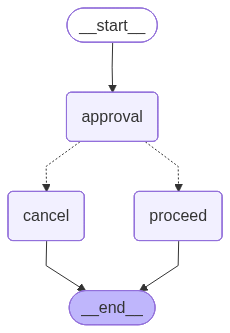

In [5]:
from IPython.display import Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "approval-123"}}
initial = graph.invoke(
    {"action_details": "Transfer $500", "status": "pending"},
    config=config,
)
print(initial["__interrupt__"])  # -> [Interrupt(value={'question': ..., 'details': ...})]

# Resume with the decision; True routes to proceed, False to cancel
resumed = graph.invoke(Command(resume=True), config=config)
print(resumed["status"])  # -> "approved"

[Interrupt(value={'question': 'Approve this action?', 'details': 'Transfer $500'}, id='cd3247f3733a51b0a0b39410dd077dc6')]
approved
